<a href="https://colab.research.google.com/github/CatIsOutOfTheBag/Probability_and_Statistics/blob/main/A_B_tests_proportions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B тесты

A/B тест для пропорций

In [ ]:
'''
Планирование эксперимента заранее:

Эван миллер simple size calculator.
- baseline: текущая конверсия
- какой минимальный эффект нужно обнаружить, напимер, увеличение конверсии на 5%
  чем меньшее отклонение необходимо обнаружить, тем большй резмер выборки потребуется
- 1-бетта мощность определяем заранее - какой процент успешных экспериментов мы обнаружили 
  в которых гипотеза Н1 отличается от нулевой на 5% и более - 80% по дефолту
- уровень значимости - тот порог, ниже которого p_value отвергает нулевую гипотезу,
  где нулевая гипотеза говорит, что разницы нет.
  Эта альфа аналог false positive - ошибка первого рода - вероятность отвергнуть верную нулевую гипотезу,
  если в ситуации, где разницы нет, сказать, что она есть

A/B тест всега учитывает двухстороннюю разницу - стало хуже/лучше
''';

In [ ]:
# проверим, все ли работает у Эвана Миллера
import pandas as pd
import numpy as np

In [ ]:
# сделаем бэйзлайн
np.random.binomial(1, 0.2, size=10000).mean() # 20% единиц в выборке, среднее покажет процент конверсии 

0.1974

In [ ]:
# смоделируем распределение с минимальным эффектом в 5%
mde = 0.05
baseline = 0.2 # 20% единиц в выборке
# и необходимый размер выборки
sample_size = 1030

In [ ]:
np.random.binomial(1, baseline, size=sample_size).mean()

0.1912621359223301

In [ ]:
np.random.binomial(1, baseline + mde, size=sample_size).mean() # бэйзлайн плюс эффект в 5%

0.229126213592233

Можно теперь проводить тесты:
- Fisher exact test
- Z test
- T test
- Chi square test (= Z test)
- Bootstrap (Monte-Carlo)

Посмотрим как будет вести себя Z-test

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# контрольная группа
a = np.random.binomial(1, baseline, size=sample_size)

In [ ]:
# тестовая группа
b = np.random.binomial(1, baseline + mde, size=sample_size)

In [ ]:
# чтобы протестировать разницу необходимо передать:
# - количество успехов в каждой группа
# - количество наблюдений в каждой группе
proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative = 'two-sided') # двусторонний тест

(-2.8887381400435697, 0.003867910274123835)

In [ ]:
# мы должны точно отвергнуть нулевую гипотезу, ведь это исходные условия, что есть разница
# но посмторим какое p_value на самом деле
from tqdm.notebook import tqdm
n = 10000
result = []
for _ in tqdm(range(n)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline + mde, size=sample_size)
  _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative = 'two-sided') # двусторонний тест
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

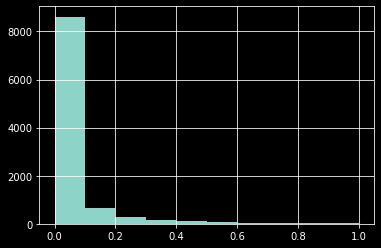

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

t = pd.Series(result)
t.hist()

In [ ]:
# смотрим в скольких % случаев p_value < 0.05
(t < 0.05).mean() # увидим дефолтные 80%

0.7717

Посмотрим как будет вести себя T-test

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
result = []
for _ in tqdm(range(n)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline + mde, size=sample_size)
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

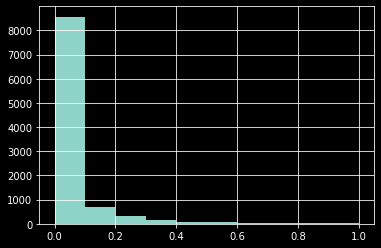

In [ ]:
t = pd.Series(result)
t.hist()

In [ ]:
(t < 0.05).mean() # увидим аналогичный результат

0.774

# A/A тест - сравнение выборок из одного распределения

Посмотрим на примере непараметрического теста Mann-Whitney

In [ ]:
from scipy.stats.mstats_basic import mannwhitneyu
result = []
for _ in tqdm(range(n)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline, size=sample_size)
  _, pval = mannwhitneyu(a,b)
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

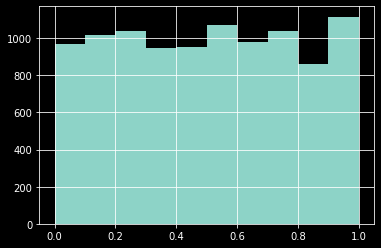

In [ ]:
t = pd.Series(result)
t.hist() # p_value должен быть распределен равномерно

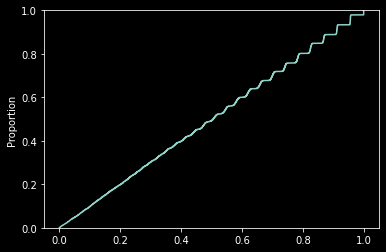

In [ ]:
# а ecdfplot должен быть приближен к прямой линии
import seaborn as sns
sns.ecdfplot(t)

In [ ]:
(t < 0.05).mean()

0.0481

Как посчитать samlpe size не Эваном Миллером, а в питоне?
Эван Миллер считает значения для выборок одинакового размера, но это не всегда соответствует жизни

In [ ]:
import statsmodels.stats.api as sms
es = sms.proportion_effectsize(0.20, 0.25)
sample_size = sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1)

In [ ]:
sample_size = round(sample_size)

In [ ]:
sample_size

1092

In [ ]:
# проверим
result = []
for _ in tqdm(range(n)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline + mde, size=sample_size)
  _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative = 'two-sided') # двусторонний тест
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
t = pd.Series(result)
(t < 0.05).mean()

0.8027

In [ ]:
# пусть отношение контрольной группы к тестовой = 1/3

es = sms.proportion_effectsize(0.20, 0.25)
sample_size = round(sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1/3))

In [ ]:
sample_size1 = sample_size # количество сэмплов в большей группе

In [ ]:
sample_size2 = round(sample_size * 1/3) # в меньшей

In [ ]:
# проведем тест. ожидемый ответ 80%
result = []
for _ in tqdm(range(n)):
  a = np.random.binomial(1, baseline, size=sample_size1)
  b = np.random.binomial(1, baseline + mde, size=sample_size2)
  _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative = 'two-sided') # двусторонний тест
  result.append(pval)

t = pd.Series(result)
(t < 0.05).mean()

  0%|          | 0/10000 [00:00<?, ?it/s]

0.795

In [ ]:
# верно

In [ ]:
'''
И еще раз:
Нулевая гипотеза утверждает, что разницы между группами нет
Успешный эксперимент обнаруживает разницу и отвергает нулевую гипотезу

Статистическая мощность (1-бетта = 80%) из 1000 успешных экспериментов (единичек) обнаружит 80%
Это вероятность правильно отвергнуть нулевую гипотезу (альтернативная гипотеза верна)

Уровень значимости альфа=5% из 1000 неуспешных экспериментов (нулей) тест в 5% случаев
даст положительный результат (единичку), скажет, что тест успешный
Это вероятность ошибочно отклонить нулевую гипотезу, когда на самом деле она истинна
''';

Перейдем от проверки гипотез в задачу классификации

Посмотрим на удачный эксперимент. Верна альтернативная гипотеза

In [ ]:
# пложим в result единички вместе с p_value
# это будет указателем на то, что прошел успешный эксперимент (разница точно есть, мы делаем +mde)

sample_size=1000
result = []
for _ in tqdm(range(n)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline + mde, size=sample_size)
  _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative = 'two-sided') # двусторонний тест
  result.append((1,pval))


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Обернем в DataFrame
t = pd.DataFrame(result, columns = ['y_true', 'y_score'])
t

,y_true,y_score
0,1,0.361515
1,1,0.001622
2,1,0.000862
3,1,0.019159
4,1,0.044433
...,...,...
9995,1,0.004958
9996,1,0.000200
9997,1,0.019566
9998,1,0.006606


In [ ]:
# здесь p_value - величина, по сути, (1 - веоятность принадлежности классу)
# чем меньше p_value (ошибка), тем ближе мы к верному классу
t['y_pred'] = t['y_score'] < 0.05

In [ ]:
t

,y_true,y_score,y_pred
0,1,0.361515,False
1,1,0.001622,True
2,1,0.000862,True
3,1,0.019159,True
4,1,0.044433,True
...,...,...,...
9995,1,0.004958,True
9996,1,0.000200,True
9997,1,0.019566,True
9998,1,0.006606,True


In [ ]:
# здесь видны ошибки
# посчитаем статистическую мощность(recall)

t['y_pred'].mean() # видим эталонные примерно 80%

0.7633

Посмотрим на НЕ удачный эксперимент. Верна нулевая гипотеза

In [ ]:
# пложим в result нолики вместе с p_value
# это будет указателем на то, что прошел НЕ успешный эксперимент (разницы точно нет)

sample_size=1000
result = []
for _ in tqdm(range(n)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline, size=sample_size)
  _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative = 'two-sided') # двусторонний тест
  result.append((0,pval))


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
t = pd.DataFrame(result, columns = ['y_true', 'y_score'])
t['y_pred'] = t['y_score'] < 0.05

In [ ]:
t

,y_true,y_score,y_pred
0,0,0.270529,False
1,0,0.647733,False
2,0,0.827650,False
3,0,0.580337,False
4,0,0.576862,False
...,...,...,...
9995,0,0.510034,False
9996,0,0.581687,False
9997,0,0.350255,False
9998,0,0.182940,False


In [ ]:
t['y_pred'].mean()

0.0504

Баланс классов 0,5

In [ ]:
# будем миксовать успешные и неуспешные эксперименты
sample_size=1090
bazeline = 0.2
mde = 0.05
result = []

class_balance = 0.5

for _ in tqdm(range(n)):
  # неуспешный эксперимент в class_balance% случаев
  if np.random.binomial(1, class_balance):
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline, size=sample_size)
    _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative = 'two-sided') # двусторонний тест
    result.append((0,pval))
  # успешный эксперимент в остальных случаях
  else:
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline + mde, size=sample_size) #есть разница mde
    _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative = 'two-sided') # двусторонний тест
    result.append((1,pval))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
t = pd.DataFrame(result, columns = ['y_true', 'y_score'])
t

,y_true,y_score
0,1,0.004988
1,0,0.830409
2,1,0.278803
3,0,0.560182
4,1,0.000010
...,...,...
9995,0,0.592345
9996,0,0.519084
9997,1,0.000622
9998,1,0.000054


In [ ]:
t['y_true'].mean() # баланс классов

0.5024

In [ ]:
t['y_pred'] = (t['y_score'] < 0.05) * 1

In [ ]:
t

,y_true,y_score,y_pred
0,1,0.004988,1
1,0,0.830409,0
2,1,0.278803,0
3,0,0.560182,0
4,1,0.000010,1
...,...,...,...
9995,0,0.592345,0
9996,0,0.519084,0
9997,1,0.000622,1
9998,1,0.000054,1


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(t['y_true'], t['y_pred']))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      4976
           1       0.95      0.79      0.86      5024

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [ ]:
# здесь ошибка первого рода - recall нулевого класса
# мощность - recall первого класса

# если тест сказал, что результат = 1, какова вероятность того, что это действительно единичка?
# посчитаем precision
t

,y_true,y_score,y_pred
0,1,0.004988,1
1,0,0.830409,0
2,1,0.278803,0
3,0,0.560182,0
4,1,0.000010,1
...,...,...,...
9995,0,0.592345,0
9996,0,0.519084,0
9997,1,0.000622,1
9998,1,0.000054,1


In [ ]:
t[t['y_pred'] == 1]['y_true'].mean()

0.9462085308056872

Изменим баланс классов

In [ ]:
# будем миксовать успешные и неуспешные эксперименты
sample_size=1090
bazeline = 0.2
mde = 0.05
result = []

class_balance = 0.95 # % неудачных экспериментоа

for _ in tqdm(range(n)):
  # неуспешный эксперимент в class_balance% случаев
  if np.random.binomial(1, class_balance):
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline, size=sample_size)
    _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative = 'two-sided') # двусторонний тест
    result.append((0,pval))
  # успешный эксперимент в остальных случаях
  else:
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline + mde, size=sample_size) #есть разница mde
    _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)], alternative = 'two-sided') # двусторонний тест
    result.append((1,pval))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
t = pd.DataFrame(result, columns = ['y_true', 'y_score'])
t['y_pred'] = (t['y_score'] < 0.05) * 1
print(classification_report(t['y_true'], t['y_pred']))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      9495
           1       0.48      0.83      0.61       505

    accuracy                           0.95     10000
   macro avg       0.74      0.89      0.79     10000
weighted avg       0.97      0.95      0.95     10000



In [ ]:
t[t['y_pred'] == 1]['y_true'].mean()

0.4805936073059361

In [ ]:
# видим, что precision уменьшился
# чем больше дисбаланс, тем ниже precision
# что делать?
# как вариант понижат уровень значимости.
# Тогда снизится recall - мы будем пропускать больше успешных экспериментов,
# но растет precision - меньше неуспешных экспериментов помечаются как успешные

Проблема множественной проверки гипотез:
из множества человек, угадывающих цвет карты кто-нибудь да угадает. случайно.
Так и в тестах, что-то может выстрелить просто потому, что оно есть
Эта проблема решается понижением уровня значимости, повышением строгости.
мы находим меньше правильных ответов, но уверены в тех немногих, что нашли

In [ ]:
'''
Об A/B тестах можно еще думать вот так:
У нас есть тесты (Z-test, T-test и др) = классификаторы
Смотрим на 1 эксперимент = 1 наблюдение
Эксперимент состоит из двух выборок, которые мы сравниваем между собой этим тестом
Подаем выборки = фичи на классификатор(тест), он выдает нам скор
Этот скор конвертируем в 0 или 1 с каким-то порогом = уровнем значимости и получаем ответ=класс
''';